In [115]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D,Flatten
from tensorflow.keras.regularizers import l2
import os
from os import listdir
import gdown
from zipfile import ZipFile
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer

In [161]:
orignal_svm = keras.models.load_model('pepper_orignal.h5')
combined_svm = keras.models.load_model('plant_strawberry_combined_BiGAN_svm.h5')
standAlone_svm = keras.models.load_model('Enhanced_strawberry_WGAN.h5')


In [162]:
def evaluate_model_svm(svm_model, test_set, label_set):
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    y_prob = svm_model.predict(test_set)
    y_pred = np.where(y_prob > 0.5, 1, 0)

    # y_pred = model.predict(x_test)
    # print(y_pred)
    # # mse = mean_squared_error(y_test, y_pred)
    # # print(mse)
    accuracy = accuracy_score(label_set, y_pred)
    precision = precision_score(label_set, y_pred)
    recall = recall_score(label_set, y_pred)
    f1 = f1_score(label_set, y_pred)
    conf_matrix = confusion_matrix(label_set, y_pred)
    
#     sns.set()
#     plt.figure(figsize=(10,8))
#     sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
#     plt.title('strawberry')
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.savefig('strawberry orignal')
#     plt.show()
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Set the font scale
    sns.set(font_scale=2.0)

    # Create the figure and axes objects
    fig, ax = plt.subplots(figsize=(2, 2), dpi=300)

    # Create the heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False, ax=ax)

    # Set the title and axis labels
    ax.set_title('strawberry', fontsize=15)
    ax.set_xlabel('Predicted Labels', fontsize=15)
    ax.set_ylabel('True Labels', fontsize=15)

    # Save the figure and show the plot
    plt.savefig('strawberry WGAN combined.png', dpi=300, bbox_inches='tight')
    plt.show()
#     print(conf_matrix)

#     print("Accuracy:", accuracy * 100)
#     print("Precision:", precision * 100)
#     print("Recall:", recall * 100)
#     print("F1-score:", f1 * 100)
    return accuracy, precision, recall, f1, conf_matrix

In [163]:
from tensorflow.keras.utils import img_to_array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            img_gan = cv2.resize(image, (32,32))
            return img_to_array(img_gan)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [164]:
def extract_plant_imgs(directory_root):
    image_list, label_list = [], []
    print("getting " + directory_root)
    try:
        print("[INFO] Loading images ...")
        root_dir = listdir(directory_root)
        #print(root_dir)
        for plant_folder in root_dir :
            # remove .DS_Store from list
            if plant_folder == ".DS_Store" :
                root_dir.remove(directory)


        for plant_folder in root_dir :
    #         print("on plant folder")
            plant_image_list = listdir(f"{directory_root}/{plant_folder}")



            for single_image in plant_image_list :

    #             print("in plant folder")
                if single_image == ".DS_Store" :
                    plant_image_list.remove(single_image)

            for image in plant_image_list[:1000]:
    #             print("getting img path")
                image_directory = f"{directory_root}/{plant_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True or image_directory.endswith(".png") == True or image_directory.endswith(".PNG") == True:
    #                 print("checking if img correct format")
                    gan_img = convert_image_to_array(image_directory)
                    image_list.append(gan_img)
                    label_list.append(plant_folder)

        print("[INFO] Image loading completed")
        return image_list, label_list
    except Exception as e:
        print(f"Error : {e}")

In [165]:
def pretty_print(accuracy, precision, recall, f1, conf, model_type ):
    print("Evaluation for " + model_type)
    print("Accuracy:", accuracy * 100)
    print("Precision:", precision * 100)
    print("Recall:", recall * 100)
    print("F1-score:", f1 * 100)
    print("True positives:", conf[0][0])
    print("False positives:", conf[0][1])
    print("False Negatives:", conf[1][0])
    print("True negatives:", conf[1][1])

In [166]:
orignal_data = 'Orignal_strawberry'

orignal_image_list , orignal_label_list = extract_plant_imgs(orignal_data)

getting Orignal_strawberry
[INFO] Loading images ...
[INFO] Image loading completed


In [167]:
new_image_list = np.array(orignal_image_list, dtype = np.float16) / 255.0
print(new_image_list.shape)

(2000, 32, 32, 3)


In [168]:
label_gen = LabelBinarizer()
image_labels = label_gen.fit_transform(orignal_label_list)
pickle.dump(label_gen,open('label_transform.pkl', 'wb'))
n_classes = len(label_gen.classes_)
print(n_classes)
print(image_labels)

2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


In [169]:
from sklearn.model_selection import train_test_split
print("making the training and testing split with 30% of the dataset as testing set")
x_train, x_test, y_train, y_test = train_test_split(new_image_list, image_labels, test_size=0.3, shuffle=True,random_state = 42) 
print(x_train.shape)
print(x_test.shape)

making the training and testing split with 30% of the dataset as testing set
(1400, 32, 32, 3)
(600, 32, 32, 3)


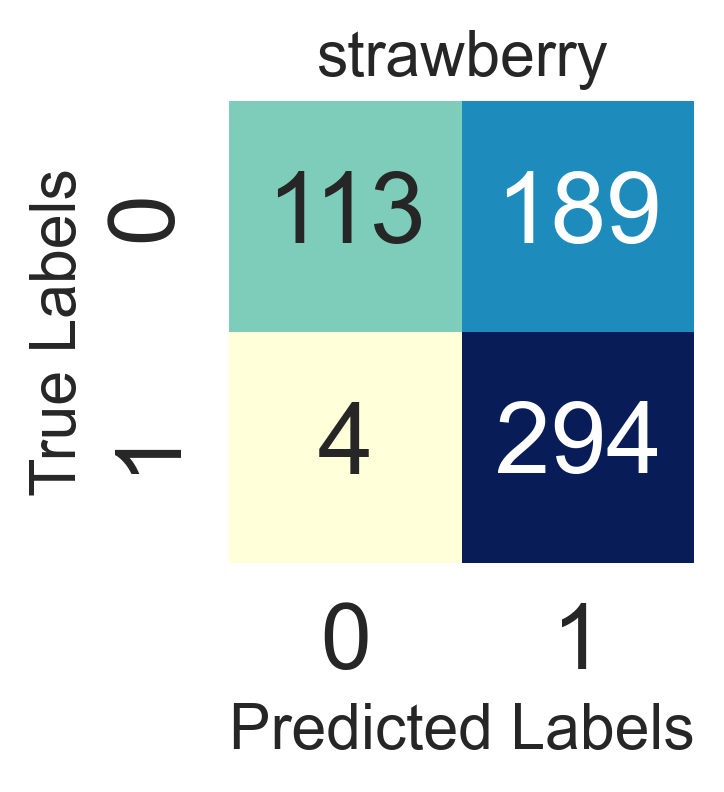

In [170]:
orig_acc, orig_prei, orig_recall, orig_f1, orig_conf_mat = evaluate_model_svm(orignal_svm, 
   x_test, y_test)

In [171]:
type_model = "CNN using orignal dataset"
pretty_print(orig_acc, orig_prei, orig_recall, orig_f1, orig_conf_mat, type_model)

Evaluation for CNN using orignal dataset
Accuracy: 67.83333333333333
Precision: 60.86956521739131
Recall: 98.65771812080537
F1-score: 75.28809218950065
True positives: 113
False positives: 189
False Negatives: 4
True negatives: 294


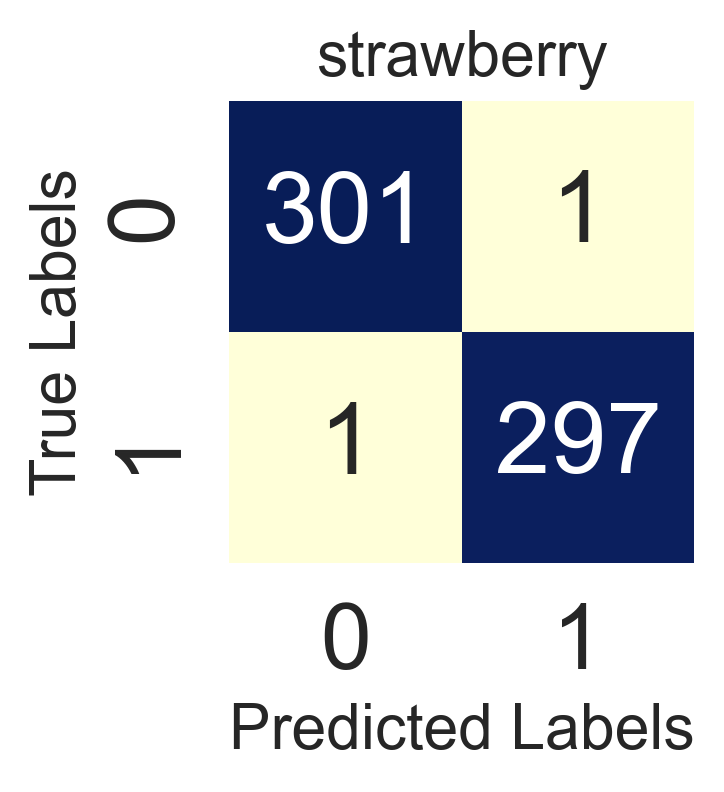

In [112]:
comb_acc, comb_prei, comb_recall, comb_f1, comb_conf = evaluate_model_svm(combined_svm, 
   x_test, y_test)

In [113]:
type_model2 = "CNN using combined dataset"
pretty_print(comb_acc, comb_prei, comb_recall, comb_f1, comb_conf, type_model2)

Evaluation for CNN using combined dataset
Accuracy: 99.66666666666667
Precision: 99.66442953020133
Recall: 99.66442953020133
F1-score: 99.66442953020133
True positives: 301
False positives: 1
False Negatives: 1
True negatives: 297


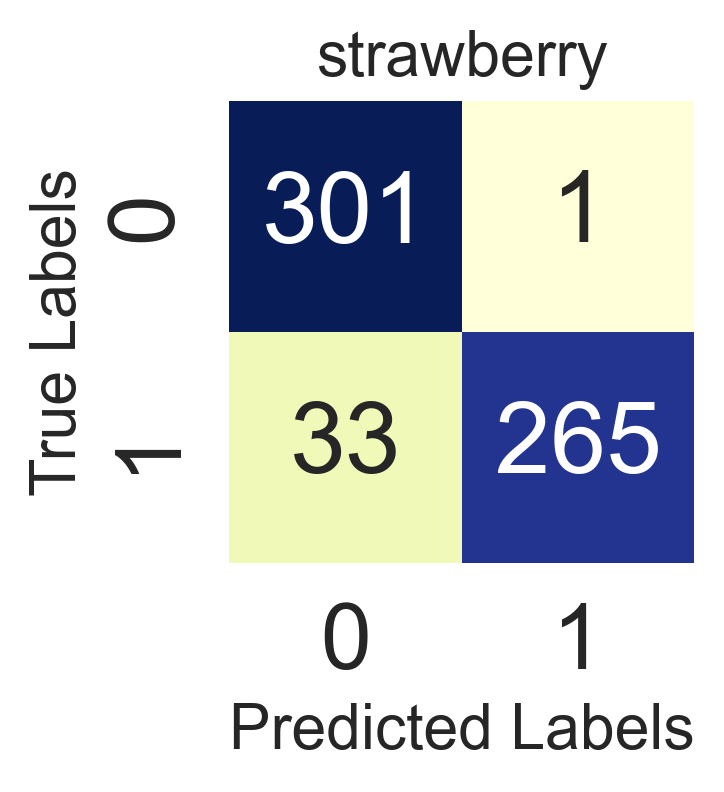

In [172]:
gen_acc, gen_prei, gen_recall, gen_f1, gen_conf = evaluate_model_svm(standAlone_svm, 
   x_test, y_test)

In [173]:
type_model3 = "CNN using only the generated dataset"
pretty_print(gen_acc, gen_prei, gen_recall, gen_f1, gen_conf, type_model3)

Evaluation for CNN using only the generated dataset
Accuracy: 94.33333333333334
Precision: 99.62406015037594
Recall: 88.9261744966443
F1-score: 93.97163120567376
True positives: 301
False positives: 1
False Negatives: 33
True negatives: 265
